In [4]:
import numpy as np
import pandas as pd
import matplotlib 
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc, plot_confusion_matrix, RocCurveDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.naive_bayes import GaussianNB

from preprocessing import *

plt.rcParams["figure.dpi"] = 60

# Carga del dataset

In [5]:
df = pd.read_csv("df_train.csv")
X = df.drop(columns=['llovieron_hamburguesas_al_dia_siguiente'])
y = df['llovieron_hamburguesas_al_dia_siguiente']
X_train, X_eval, y_train, y_eval = train_test_split(X, y, random_state=117, test_size=0.1, stratify=y.astype(str))

# Selección de modelos

Buscamos el mejor valor del parámetro var_smoothing, en dos datasets distintos: preprocessing_arboles_2(df) y preprocessing_arboles_4(df), utilizando Randomized Search.

In [6]:
X_train1 = preprocessing_arboles_2(X_train)

params = {
    'var_smoothing': np.arange(0.0001, 1, 0.0001)
}

gnb1 = GaussianNB()

rgscv1 = RandomizedSearchCV(
    gnb1, params, n_iter=60, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train1, y_train)

print(f"Best score: {rgscv1.best_score_}")
print(f"Best params {rgscv1.best_params_}")

Best score: 0.8350176147858086
Best params {'var_smoothing': 0.008}


In [7]:
X_train2 = preprocessing_arboles_4(X_train)

params = {
    'var_smoothing': np.arange(0.0001, 1, 0.0001)
}

gnb2 = GaussianNB()

rgscv2 = RandomizedSearchCV(
    gnb2, params, n_iter=60, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train2, y_train)

print(f"Best score: {rgscv2.best_score_}")
print(f"Best params {rgscv2.best_params_}")

Best score: 0.825158020220149
Best params {'var_smoothing': 0.161}


# Evaluación del modelo final

El mejor modelo encontrado corresponde al preprocesamiento preprocessing_arboles_2(), con 'var_smoothing' = 0.0353.
Entrenamos el modelo y evaluamos utilizando el set de holdout.

In [8]:
X_eval = preprocessing_arboles_2(X_eval)

gnb = GaussianNB(var_smoothing=0.008)
gnb.fit(X_train1, y_train)

y_pred = gnb.predict(X_eval)
y_pred_proba = gnb.predict_proba(X_eval)[:,1]

In [9]:
print(f"Auc Roc: {roc_auc_score(y_eval, y_pred_proba)}")
print(f"Accuracy: {accuracy_score(y_eval, y_pred)}")
print(f"Precision: {precision_score(y_eval, y_pred)}")
print(f"Recall: {recall_score(y_eval, y_pred)}")
print(f"F1 Score: {f1_score(y_eval, y_pred)}")

Auc Roc: 0.8417041459235761
Accuracy: 0.8260217847506746
Precision: 0.6132945172246482
Recall: 0.572463768115942
F1 Score: 0.592176153665964


## Matriz de confusión

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


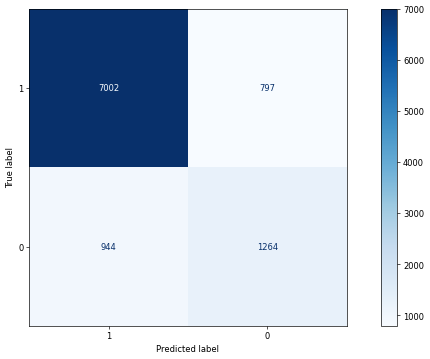

In [10]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.grid(False)
plot_confusion_matrix(
    gnb, X_eval, y_eval, cmap=plt.cm.Blues, display_labels=['1', '0'], ax=ax
)
plt.show()

## Curva ROC

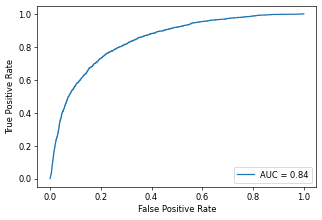

In [11]:
fpr, tpr, thresholds = roc_curve(y_eval, y_pred_proba)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()

# Predicciones finales

In [13]:
df_pred = pd.read_csv("pred.csv")
df_pred_preprocess = basic_preprocessing(df_pred, prediction_dataset=True)
df_pred_preprocess = fill_numerical_missings(df_pred_preprocess, X_train)
df_pred_preprocess = df_pred_preprocess.drop(columns = ['id'])
df_pred_preprocess = preprocessing_arboles_2(df_pred_preprocess)

y_pred_final = gnb.predict(df_pred_preprocess)
df_pred_final = pd.DataFrame({'id': df_pred['id'], 'llovieron_hamburguesas_al_dia_siguiente': y_pred_final})
df_pred_final.loc[df_pred_final['llovieron_hamburguesas_al_dia_siguiente'] == 1, 'llovieron_hamburguesas_al_dia_siguiente'] = 'si'
df_pred_final.loc[df_pred_final['llovieron_hamburguesas_al_dia_siguiente'] == 0, 'llovieron_hamburguesas_al_dia_siguiente'] = 'no'

df_pred_final['llovieron_hamburguesas_al_dia_siguiente'].value_counts()

no    23117
si     5975
Name: llovieron_hamburguesas_al_dia_siguiente, dtype: int64

In [14]:
df_pred_final.to_csv('predicciones/naive_bayes.csv', index=False)